# Function Encoders: A principled approach to transfer and online adaptation

This tutorial is an introduction to function encoders. Function encoders learn basis functions for a function space $\mathcal{F}$, where each basis function is a neural network. In other words, every function is represented as a linear combination of the learned basis:

$$
f(x) = \sum_{i=1}^k c_i g_i(x ; \theta_i)
$$ 

The coefficients $c$ can be computed as the solution to a simple least-squares problem:

\begin{equation}
c = \begin{bmatrix}
\langle g_1, g_1 \rangle_\mathcal{F} & ... & \langle g_1, g_k \rangle_\mathcal{F} \\
\vdots & \ddots & \vdots \\
\langle g_k, g_1 \rangle_\mathcal{F} & ... & \langle g_k, g_k \rangle_\mathcal{F} \\
\end{bmatrix}^{-1}
\begin{bmatrix}
\langle f, g_1 \rangle_\mathcal{F} \\
\vdots \\
\langle f, g_k \rangle_\mathcal{F} \\
\end{bmatrix}
\end{equation}

The function encoder is useful because only a small amount of data is needed to compute the coefficients, and the resulting model adapts to the data it is given.  For example, prior work has used function encoders to model the dynamics of a robot, where a small amount of online data is used to compute the coefficients. The resulting dynamics model is calibrated to the robot's current environment, and yields accurate state estimates. Furthermore, basis functions are applicable to almost any setting, including few-shot image classification, pose estimation, operator learning, PDE modeling, etc.


In this introduction,  we will learn basis functions for a simple function space; the space of quadratic functions:

$$
\mathcal{H} = \{f \; | \; f(x) = ax^2 + bx + c  \quad \quad  a,b,c \in \mathbb{R}\}
$$

The first thing we will do is define the datasets. The following code segment defines the function $f(x) = ax^2 + bx + c$. Then it samples 100 values each of a,b, and c. Lastly, it samples data from (-1,1) and computes the output for each function. 

In [105]:
import torch
import matplotlib.pyplot as plt

from neuromancer.dataset import DictDataset
from neuromancer.system import Node
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer


from FunctionEncoder import FunctionEncoder


def create_dataset(f, device='cpu',test=False):

    # batch size
    n_functions = 100
    n_datapoints = 1000

    # samples from -1 to 1
    example_xs = torch.rand(n_functions, 50, 1) * 2 - 1
    if not test:
        query_xs = torch.rand(n_functions, n_datapoints, 1) * 2 - 1
    else:
        query_xs = torch.linspace(-1, 1, n_datapoints).reshape(-1, 1).repeat(n_functions, 1, 1)

    # sample a,b,c from -3 to 3 for n_functions size
    a = torch.rand(n_functions, 1, 1) * 6 - 3
    b = torch.rand(n_functions, 1, 1) * 6 - 3
    c = torch.rand(n_functions, 1, 1) * 6 - 3

    example_ys = f(example_xs, a, b, c)
    query_ys = f(query_xs, a, b, c)


    dataset = {"example_xs": example_xs.to(device),
                "example_ys": example_ys.to(device),
                "query_xs": query_xs.to(device),
                "query_ys": query_ys.to(device),
                "a": a.to(device),  # NOTE: a,b,c are only used for plotting.
                "b": b.to(device),
                "c": c.to(device),
                }

    return dataset


# Function to sample from
f = lambda x, a, b, c: a * x ** 2 + b * x + c

# Create dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = create_dataset(f, device=device)
test_dataset = create_dataset(f, device=device, test=True)

Next, we will wrap these dictionaries in some convenient wrappers

In [106]:
# Wrap data into Neuromancer DictDatasets
train_data = DictDataset(train_dataset, name='train')
dev_data = DictDataset(test_dataset, name='dev')

# Create torch dataloaders with DictDatasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=20,
                                         collate_fn=dev_data.collate_fn,
                                         shuffle=False)

The function encoder algorithm requires neural network basis functions. Let's initialize those now. We can also wrap it in the FunctionEncoder class. The forward method of the function encoder takes three inputs: "example_xs", "example_ys", and "query_xs". The example data is used to compute the coefficients of the basis functions, and then the model estimates the "query_ys" as a linear combination of the basis functions. As these are just estimates, they are labeled as "query_y_hats". It also outputs the Gram matrix, which is useful for regularization.  

In [107]:
# Initialize basis functions for the function encoder.
n_basis = 3
basis_functions = [torch.nn.Sequential(
    torch.nn.Linear(1, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 1),
) for i in range(n_basis)]
# the function encoder class provides convenient methods to calibrate estimates using least squares
# specifically, it uses example data to compute the coefficients of the basis functions,
# then uses a linear combination of the basis functions to estimate the function
function_encoder = FunctionEncoder(basis_functions)

Let's also wrap in it in the NeuroMancer interface.

In [108]:
# Symbolic wrapper of the neural nets
function_encoder = Node(function_encoder, ['example_xs', 'example_ys', 'query_xs'], ['query_y_hats', 'gram'], name='function_encoder')

# Define symbolic variables in Neuromancer
# these are the variables used in the loss functions
query_y_hats = variable('query_y_hats')
query_ys = variable('query_ys')
gram = variable('gram')

Next, we will define the loss for the function encoder. The primary loss is simply the prediction error between query_ys and query_y_hats. We also apply regularization to the Gram matrix.

In [109]:
# Define the losses
# The first ensures the function estimates align with the true function
loss_data = (query_y_hats == query_ys)^2
loss_data.name = "loss_data"

# this prevents the magnitude of the basis functions from growing
loss_gram = (torch.diagonal(gram, dim1=1, dim2=2) == torch.ones_like(torch.diagonal(gram, dim1=1, dim2=2)))^2
loss_gram.name = "loss_gram"

loss = PenaltyLoss(objectives=[loss_data, loss_gram], constraints=[])

Now, we are ready to train.

In [110]:
# Construct the optimization problems
problem = Problem(nodes=[function_encoder], loss=loss)

# Create trainer
num_epochs = 200
trainer = Trainer(
    problem.to(device),
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer= torch.optim.Adam(problem.parameters(), lr=1e-3),
    epoch_verbose=50,
    epochs=num_epochs,
    warmup=num_epochs,
    device=device
)

# Train function encoder
best_model = trainer.train()

epoch: 0  train_loss: 0.825278103351593
epoch: 50  train_loss: 0.002963538747280836
epoch: 100  train_loss: 0.002753085922449827
epoch: 150  train_loss: 0.0026730720419436693


After training, let's fetch the best model and plot the results.

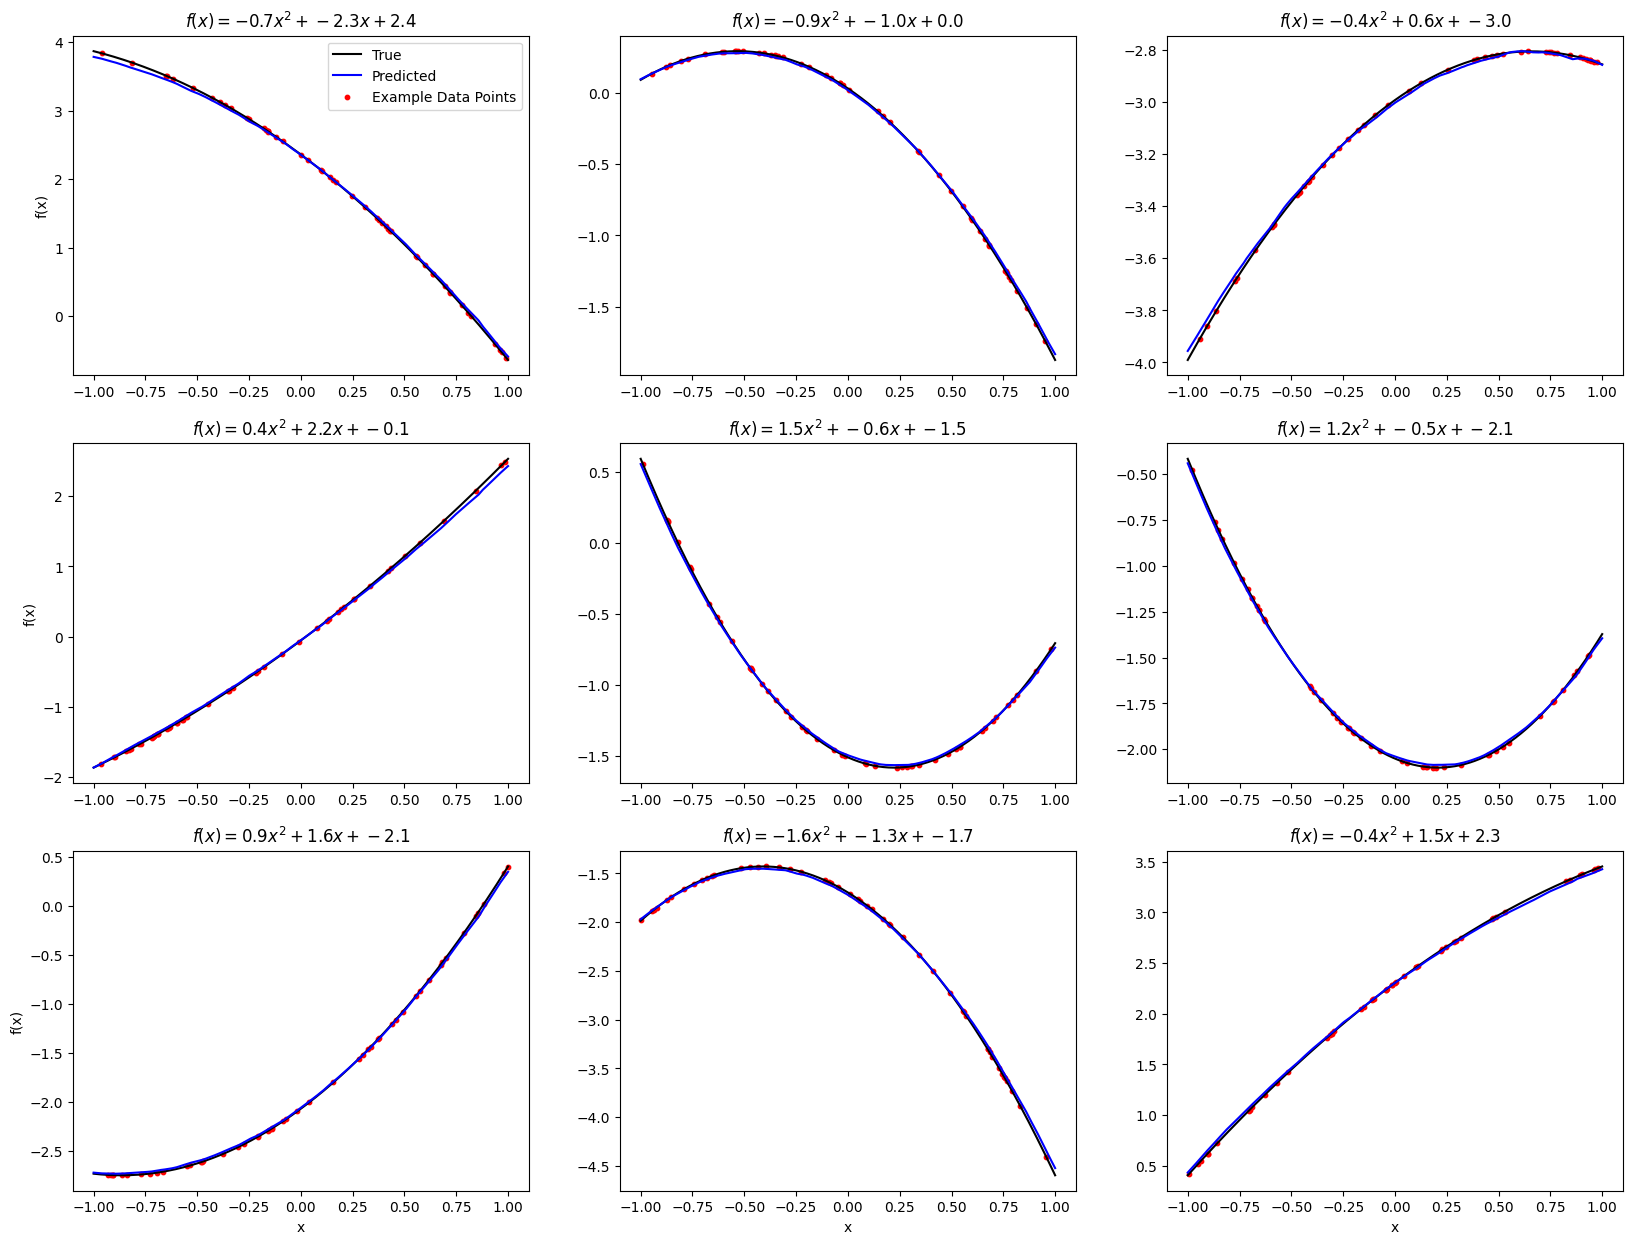

In [111]:
# get best model
problem.load_state_dict(best_model)
trained_model = problem.nodes[0]

# estimate outputs and plot.
with torch.no_grad():
    y_test_pred = trained_model(dev_data.datadict)['query_y_hats'].cpu().detach().numpy()
    query_ys = dev_data.datadict['query_ys'].cpu().detach().numpy()

    fig, axs = plt.subplots(3, 3, figsize=(20, 15))
    for i in range(9):
        # plot the estimates
        ax = axs[i // 3, i % 3]
        ax.plot(dev_data.datadict['query_xs'][i].cpu().detach().numpy(), query_ys[i], label='True', color="black")
        ax.plot(dev_data.datadict['query_xs'][i].cpu().detach().numpy(), y_test_pred[i], label='Predicted', color="blue")
        ax.scatter(dev_data.datadict['example_xs'][i].cpu().detach().numpy(),
                   dev_data.datadict['example_ys'][i].cpu().detach().numpy(), color='red', label='Example Data Points', s=10)

        a = dev_data.datadict['a'][i].cpu().detach().item()
        b = dev_data.datadict['b'][i].cpu().detach().item()
        c = dev_data.datadict['c'][i].cpu().detach().item()
        ax.set_title(f"$f(x) = {a:0.1f}x^2 + {b:0.1f}x + {c:0.1f}$")

        # set labels
        if i // 3 == 2:
            ax.set_xlabel('x')
        if i % 3 == 0:
            ax.set_ylabel('f(x)')

        # set legend
        if i == 0:
            ax.legend(loc='upper right')


And we're done! Above you can see 9 quadratic functions plotted in black. The red points indicate the data used to compute the coefficients, and the blue curve is the estimated function. All of these estimates use the same basis functions. We can plot the basis functions too:

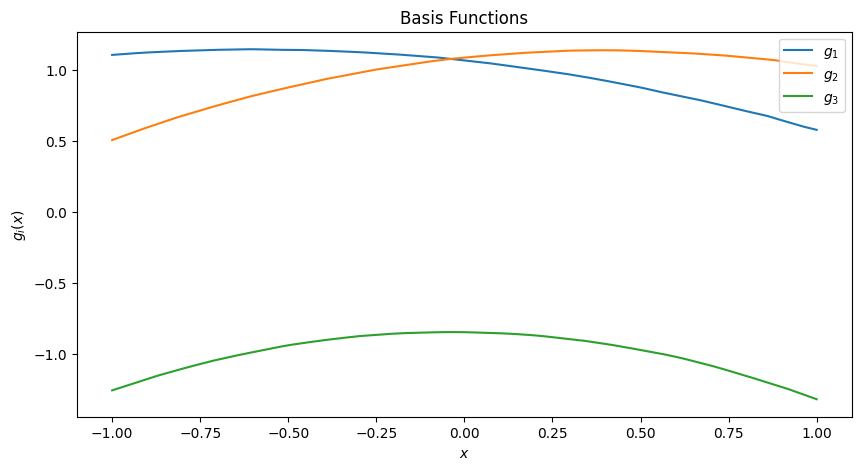

In [112]:
basis_functions = trained_model.callable.forward_basis_functions(dev_data.datadict['query_xs'])


fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i in range(n_basis):
    xs = dev_data.datadict['query_xs'][0].cpu().detach().numpy()
    ys = basis_functions[0][..., i].cpu().detach().numpy()
    ax.plot(xs, ys, label=f'$g_{i + 1}$')
ax.set_title('Basis Functions')
ax.set_xlabel('$x$')
ax.set_ylabel('$g_i(x)$')
ax.legend(loc='upper right')


As you can see, all of the basis functions are quadratic-looking functions. This is what we would expect, since these basis functions have been trained to span the space of quadratics! This is the end of this tutorial. For more information on function encoders, see the following papers:
* [Function Encoders: A Principled Approach to Transfer Learning in Hilbert Spaces (ICML 2025)](https://arxiv.org/abs/2501.18373)
* [Zero-Shot Transfer of Neural ODEs (NeurIPS 2024)](https://arxiv.org/abs/2405.08954)
* [Basis-to-Basis Operator Learning Using Function Encoders (CMAME 2024)](https://arxiv.org/abs/2410.00171)
* [Zero-Shot Reinforcement Learning via Function Encoders (ICML 2024)](https://arxiv.org/abs/2401.17173)


